# Fasion MNIST CNN

In [9]:
# Import:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
    print("Device:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU
Device: GeForce GTX 960M


In [11]:
# data_transform and batch_size:
data_transform = transforms.ToTensor()
batch_size = 30

# Choose the training and test datasets:
train_data = FashionMNIST(root='./data/datasets/FashionMNIST', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./data/datasets/FashionMNIST', train=False, download=True, transform=data_transform)

# Prepare data loaders:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Specify the image classes:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Print out some stats about the training and test data:
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))
print('Classes: ', classes)

Train data, number of images:  60000
Test data, number of images:  10000
Classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


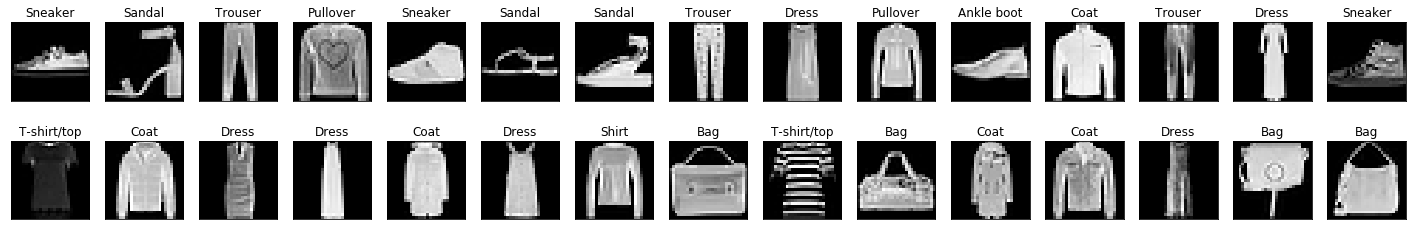

In [12]:
# Obtain one batch of training images:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 
        # 10 output channels/feature maps, 
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26 => output Tensor = (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # 2 kernel_size,
        # 2 stride
        ## output size = (10, 13, 13)
        self.pool = nn.MaxPool2d(2, 2)
        
        # 10 inputs, 
        # 20 output channels/feature maps, 
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11 => output Tensor = (20, 11, 11)
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x
        

In [13]:
# Instantiate the network
model = Net().to(device)
print(model)

# Specify loss function (criterion) and the optimiser:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [16]:
# Define Training Loop:
def train(n_epochs, stat_every=1000):
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            inputs, labels = data               # get the input data and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()               # zero the parameter (weight) gradients
            outputs = model(inputs)             # forward pass to get outputs
            loss = criterion(outputs, labels)   # calculate the loss
            loss.backward()                     # backward pass to calculate the parameter gradients
            optimizer.step()                    # update the parameters
            running_loss += loss.item()         # convert loss into a scalar and add it to running_loss
            
            if batch_i % stat_every == stat_every-1:
                avg_loss = running_loss/stat_every
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('INFO:    Finished Training')
    return loss_over_time

In [ ]:
# Train the Network:
epochs = 3

training_loss = train(epochs)